In [2]:
import pandas as pd

disc_rate = 0.07
t0 = 2019

def discount_rate(t0, disc_rate):
    discount_rate_1 = []
    discount_rate_05 = []
    for date in range(t0,2051):
        t = (date - t0)
        t1 = t
        t05 = t/2
        rate1 = 1 / ((1 + disc_rate) ** t1)
        rate2 = 1 / ((1 + disc_rate) ** t05)

        discount_rate_1.append({'date': date, 'rate': rate1})
        discount_rate_05.append({'date': date, 'rate': rate2})
     
    return pd.DataFrame(discount_rate_1),pd.DataFrame(discount_rate_05)

def decompose_LCOH(file_path, run_name):
    disc_rate = 0.07
    t0 = 2019
    
    attribute = ['Cost_Inv','Cost_Fom','VAR_FIn','VAR_FOut']

    lcoh_res = pd.DataFrame()
    for att in attribute:
        print(att)
        att_df = pd.read_csv(file_path + att +'_' + run_name + '.csv', sep = ',')
        if att == 'VAR_Ncap':
            att_df = att_df[att_df['2'].str.contains('H2prd')]
            att_df['group'] = att_df['3'].astype(str).str.cat(att_df['2'].astype(str), sep='_').str.cat(att_df['4'].astype(str), sep='_')
            att_df[att] = att_df['8']
            att_df = att_df[~att_df['group'].duplicated()]
            att_df = att_df[['group','3',att]]
            years_att_df = pd.DataFrame()
            for years in att_df['3'].unique():
                years_lcoh = att_df[att_df['3'] == years]
                time_d_rate1 = d_rate1[(d_rate1['date'] >= int(years) - 5) & (d_rate1['date'] < int(years) + 1)]
                time_npv1 = time_d_rate1['rate'].sum()
                
                years_lcoh[att] = years_lcoh[att]*time_npv1
                years_att_df =  pd.concat([years_att_df,years_lcoh], axis = 0)

            if lcoh_res.empty:
                lcoh_res = pd.concat([lcoh_res,years_att_df],axis=0)
                lcoh_res.drop(columns=['3'],inplace=True)

            else:
                lcoh_res = pd.merge(lcoh_res,years_att_df, how='outer',on='group')
                lcoh_res.drop(columns=['3'],inplace=True)
        
        if att == 'Cost_Inv':
            att_df = att_df[(att_df['7'].str.contains('INV')) & (att_df['2'].str.contains('H2prd'))]

            if att_df.empty:
                pass
            else:
                att_df['group'] = att_df['5'].astype(str).str.cat(att_df['2'].astype(str), sep='_').str.cat(att_df['4'].astype(str), sep='_')
                att_df[att] = att_df['8']
                att_df = att_df[~att_df['group'].duplicated()]
                att_df = att_df[['group','3','4','2',att]]

            if lcoh_res.empty:
                lcoh_res = pd.concat([lcoh_res,att_df],axis=0)

            else:
                lcoh_res = pd.merge(lcoh_res,att_df, how='outer',on='group') 
            
        if att == 'Cost_Fom':
            att_df = att_df[att_df['2'].str.contains('H2prd')]
            att_df['group'] = att_df['5'].astype(str).str.cat(att_df['2'].astype(str), sep='_').str.cat(att_df['4'].astype(str), sep='_')
            att_df[att] = att_df['8']
            att_df = att_df[~att_df['group'].duplicated()]
            att_df = att_df[['group',att]]
            if lcoh_res.empty:
                lcoh_res = pd.concat([lcoh_res,att_df],axis=0)

            else:
                lcoh_res = pd.merge(lcoh_res,att_df, how='outer',on='group') 

       
            

        if att == 'VAR_FIn':
            att_df = att_df[att_df['2'].str.contains('H2prd')]
            att_df['grp_proc'] = att_df['5'].astype(str).str.cat(att_df['2'].astype(str), sep='_').str.cat(att_df['4'].astype(str), sep='_')
            
            eq_comn_df = pd.DataFrame()
            for process in att_df['grp_proc'].unique():
                process_df = att_df[att_df['grp_proc'] == process]
                list_input = list(process_df['1'].unique())
                
                att_eq_comb = pd.read_csv(file_path + 'EQ_CombalM' +'_' + run_name + '.csv', sep = ',')
                att_eq_comb = att_eq_comb[att_eq_comb['1'].isin(list_input)]
                att_eq_comb['grp'] = att_eq_comb['3'].astype(str).str.cat(att_eq_comb['1'].astype(str), sep='_').str.cat(att_eq_comb['6'].astype(str), sep='_').str.cat(att_eq_comb['4'].astype(str), sep='_')
                att_eq_comb.rename(columns={'8': 'eq_combal'}, inplace=True)
                att_eq_comb = att_eq_comb[['grp','eq_combal']]

                process_df['grp'] = process_df['5'].astype(str).str.cat(process_df['1'].astype(str), sep='_').str.cat(process_df['6'].astype(str), sep='_').str.cat(process_df['4'].astype(str), sep='_')
                process_df.rename(columns={'8': 'var_fin'}, inplace=True)
                process_df = process_df[['grp','var_fin','2','4','5']]
                

                cost_df = pd.merge(att_eq_comb,process_df, how='outer',on='grp').dropna()
                
                cost_df['cost_flow'] = cost_df['eq_combal']*cost_df['var_fin']
               
                cost_df['5'] = cost_df['5'].astype(int)
                cost_df['group'] = cost_df['5'].astype(str).str.cat(cost_df['2'].astype(str), sep='_').str.cat(cost_df['4'].astype(str), sep='_')
                cost_df['flow_cost_grp'] = cost_df.groupby('group')['cost_flow'].transform('sum')
                cost_df = cost_df[~cost_df['group'].duplicated()]
                cost_df = cost_df[['group','flow_cost_grp']].reset_index(drop=True)
                
 
                eq_comn_df = pd.concat([eq_comn_df,cost_df], axis = 0)

            lcoh_res = pd.merge(lcoh_res,eq_comn_df, how='outer',on='group')

        if att == 'VAR_FOut':
            att_df = att_df[att_df['2'].str.contains('H2prd')]
            att_df = att_df[(att_df['6'] != 'ANNUAL')]
            att_df['group'] = att_df['5'].astype(str).str.cat(att_df['2'].astype(str), sep='_').str.cat(att_df['4'].astype(str), sep='_')
            att_df[att] = att_df['8']
            att_df = att_df[~att_df['group'].duplicated()]
            att_df = att_df[['group',att]]
            if lcoh_res.empty:
                lcoh_res = pd.concat([lcoh_res,att_df],axis=0)

            else:
                lcoh_res = pd.merge(lcoh_res,att_df, how='outer',on='group') 
    lcoh_res = lcoh_res.dropna()


    d_rate1,d_rate05  = discount_rate(t0,disc_rate)

    lcoh_res['years'] = lcoh_res['group'].str.split('_').str[0]
    final_lcoh = pd.DataFrame()
    for years in lcoh_res['years'].unique():
        years_lcoh = lcoh_res[lcoh_res['years'] == years]
        time_d_rate1 = d_rate1[(d_rate1['date'] >= int(years) - 5) & (d_rate1['date'] < int(years) + 1)]
        time_d_rate1 = d_rate1[(d_rate1['date'] == int(years))]

        time_npv1 = time_d_rate1['rate'].sum()

        years_lcoh['lcoh'] = ( pd.to_numeric(years_lcoh['Cost_Inv'])*time_npv1  + pd.to_numeric(years_lcoh['Cost_Fom'])*time_npv1 + pd.to_numeric(years_lcoh['flow_cost_grp'])*time_npv1) / pd.to_numeric(years_lcoh['VAR_FOut'])*time_npv1
        final_lcoh = pd.concat([final_lcoh,years_lcoh],axis=0)
    
    final_lcoh['total_costs'] = final_lcoh['Cost_Inv']+final_lcoh['Cost_Fom']+final_lcoh['flow_cost_grp']
    final_lcoh[['Cost_Inv%','Cost_Fom%','flow_cost_grp%']] = final_lcoh[['Cost_Inv','Cost_Fom','flow_cost_grp']].div(final_lcoh['total_costs'], axis=0)
    final_lcoh['lcoh_final'] = final_lcoh.groupby('group')['lcoh'].transform('sum')
    return final_lcoh
    

Cost_Inv
Cost_Fom
VAR_FIn


C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_df['grp'] = process_df['5'].astype(str).str.cat(process_df['1'].astype(str), sep='_').str.cat(process_df['6'].astype(str), sep='_').str.cat(process_df['4'].astype(str), sep='_')
C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_df.rename(columns={'8': 'var_fin'}, inplace=True)
C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:129: SettingWithCopyWa

VAR_FOut


C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:37: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  att_df = pd.read_csv(file_path + att +'_' + run_name + '.csv', sep = ',')


0.2415130867419331
0.17219549301143863
0.12277300668653232
0.33873459779659754


C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years_lcoh['lcoh'] = ( pd.to_numeric(years_lcoh['Cost_Inv'])*time_npv1  + pd.to_numeric(years_lcoh['Cost_Fom'])*time_npv1 + pd.to_numeric(years_lcoh['flow_cost_grp'])*time_npv1) / pd.to_numeric(years_lcoh['VAR_FOut'])*time_npv1 #pd.to_numeric(years_lcoh['VAR_Ncap'])*time_npv1 +
C:\Users\trouvebe\AppData\Local\Temp\ipykernel_20744\2401887985.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

,group,3,4,2,Cost_Inv,Cost_Fom,flow_cost_grp,VAR_FOut,years,lcoh,total_costs,Cost_Inv%,Cost_Fom%,flow_cost_grp%,lcoh_final
0,2040_H2prd_Elc_ALK01_Africa_north,2040,Africa_north,H2prd_Elc_ALK01,278.219043,50.307123,1810.264618,12.502040,2040,9.978580,2138.790785,0.130082,0.023521,0.846396,9.978580
4,2040_H2prd_Elc_ALK01_Arg-Chi,2040,Arg-Chi,H2prd_Elc_ALK01,668.860584,120.942302,3052.517985,21.131311,2040,10.605924,3842.320872,0.174077,0.031476,0.794446,10.605924
7,2040_H2prd_Elc_ALK01_Asia_central,2040,Asia_central,H2prd_Elc_ALK01,90.965473,16.448232,31.918334,4.087621,2040,1.988207,139.332039,0.652868,0.118051,0.229081,1.988207
8,2040_H2prd_Gas_SR01CCS_Asia_central,2040,Asia_central,H2prd_Gas_SR01CCS,124.513656,45.028721,377.667895,4.689546,2040,6.806201,547.210273,0.227543,0.082288,0.690170,6.806201
11,2040_H2prd_Elc_ALK01_Asia_east,2040,Asia_east,H2prd_Elc_ALK01,1535.310686,277.612426,2470.083013,68.990662,2040,3.621093,4283.006125,0.358466,0.064817,0.576717,3.621093
18,2040_H2prd_Elc_ALK01_Australia_NZ,2040,Australia_NZ,H2prd_Elc_ALK01,360.089269,65.110766,730.988247,16.005078,2040,4.213588,1156.188283,0.311445,0.056315,0.632240,4.213588
25,2040_H2prd_Elc_ALK01_China,2040,China,H2prd_Elc_ALK01,16584.903380,2998.855736,43852.780600,745.258583,2040,4.964938,63436.539716,0.261441,0.047273,0.691286,4.964938
41,2040_H2prd_Elc_ALK01_EU_southwest,2040,EU_southwest,H2prd_Elc_ALK01,428.770861,77.529662,894.931450,19.267231,2040,4.242014,1401.231974,0.305996,0.055330,0.638675,4.242014
50,2040_H2prd_Elc_ALK01_India,2040,India,H2prd_Elc_ALK01,6376.151088,1152.925454,19190.880418,286.518481,2040,5.439569,26719.956960,0.238629,0.043148,0.718223,5.439569
59,2040_H2prd_Gas_SR01CCS_MidEast_other,2040,MidEast_other,H2prd_Gas_SR01CCS,1584.641079,573.064537,1440.421463,59.682187,2040,3.516520,3598.127080,0.440407,0.159267,0.400325,3.516520


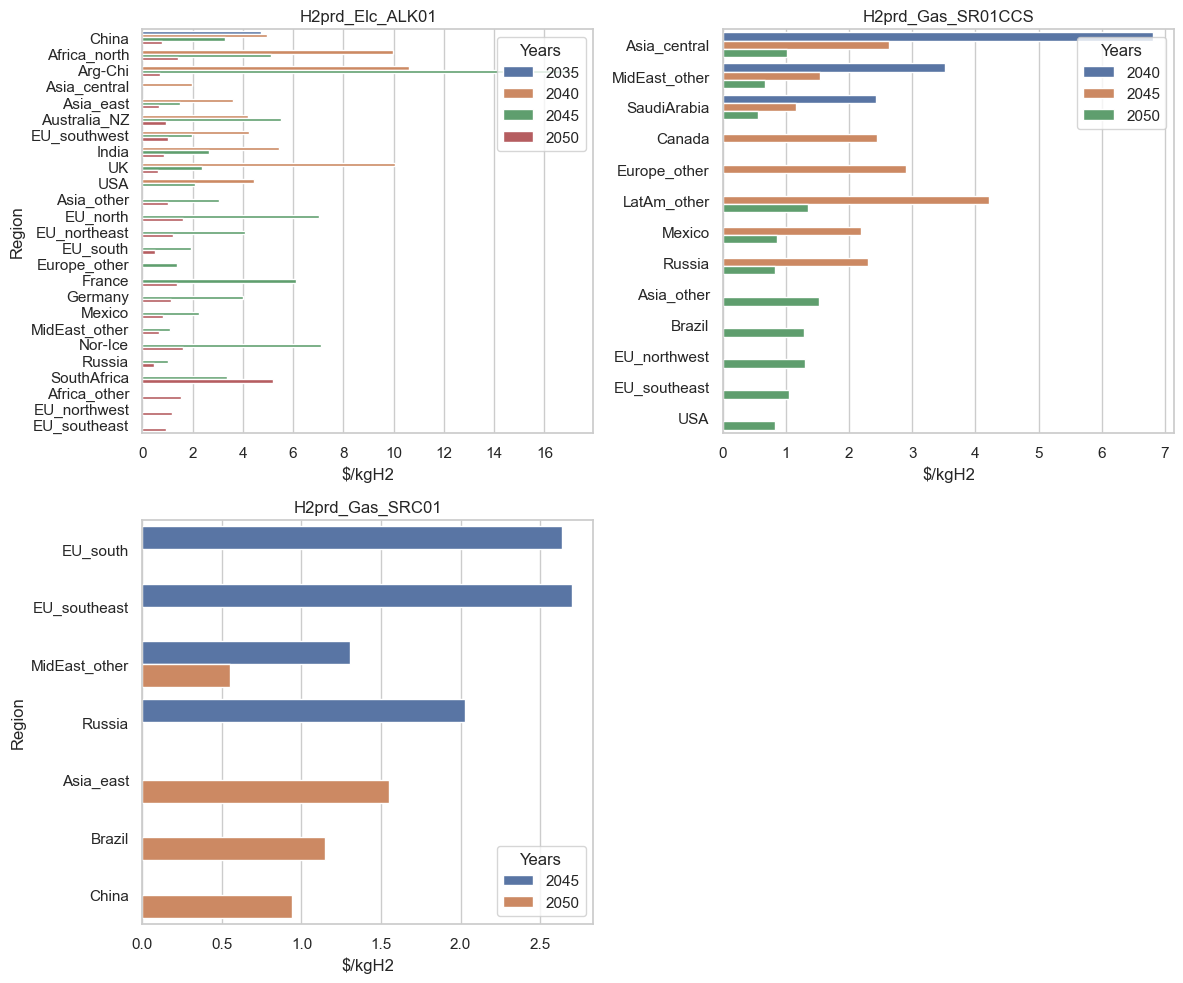

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
import seaborn as sns



def lcoh_plot(file_path,run_name,output_folder):
    lcoh_df = decompose_LCOH(file_path, run_name)
    pivot_df = lcoh_df.pivot_table(index=['4', '2'], columns='3', values='lcoh_final').reset_index()

    # Melt the DataFrame back to long format for seaborn
    melted_df = pivot_df.melt(id_vars=['4', '2'], value_vars=[2035, 2040, 2045, 2050], 
                            var_name='3', value_name='lcoh_final')

    # Plotting
    # sns.set(style="whitegrid")

    # Initialize the matplotlib figure
    pivot_df = lcoh_df.pivot_table(index=['4', '2'], columns='3', values='lcoh_final').reset_index()

    # Melt the DataFrame back to long format for seaborn
    melted_df = pivot_df.melt(id_vars=['4', '2'], value_vars=[2035, 2040, 2045, 2050], 
                            var_name='3', value_name='lcoh_final')
    melted_df = melted_df.dropna()
    melted_df.head(30)

    # Plotting
    sns.set(style="whitegrid")

    # Initialize the matplotlib figure
    processes = melted_df['2'].unique()
    num_processes = len(processes)

    # Initialize the matplotlib figure
    nrows = (num_processes + 1) // 2  # Calculate number of rows needed
    f, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5 * nrows))

    # If there's only one subplot, axes will be a single Axes object
    if num_processes == 1:
        axes = [axes]

    # Flatten axes array for easier iteration if needed
    axes = axes.flatten()

    # Plotting
    sns.set(style="whitegrid")

    for ax, process in zip(axes, processes):
        process_data = melted_df[melted_df['2'] == process]
        sns.barplot(x="lcoh_final", y="4", hue="3", data=process_data, ax=ax, dodge=True, errorbar=None)
        ax.set_title(process)
        ax.set_xlabel("$/kgH2")
        ax.set_ylabel("")
        ax.legend(title='Years')

    for ax in axes[::2]:  # First column of subplots
        ax.set_ylabel("Region")

    # Hide any unused subplots
    for ax in axes[num_processes:]:
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(output_folder + 'lcoh_decomposed.pdf'
                    , format ='pdf',
                    bbox_inches='tight')
# Remove the top and right spines for a cleaner look
# sns.despine(left=True, bottom=True)



# plt.figure(figsize=(14, 10))

# # Get unique countries
# countries = melted_df['4'].unique()
# num_countries = len(countries)

# # Define bar width and position for each country
# bar_width = 0.6
# num_years = len(sorted(melted_df['3'].unique()))
# x = np.arange(num_countries)

# # Plot bars for each year
# for i, year in enumerate(sorted(melted_df['3'].unique())):
#     year_data = melted_df[melted_df['3'] == year]
#     bar_positions = x + i * bar_width
#     plt.barh(bar_positions, year_data['lcoh_final'], height=bar_width, label=str(year))

# # Adjust x-ticks and labels
# plt.yticks(x + bar_width * num_years / 2, countries)
# plt.xlabel("Values")
# plt.ylabel("Country")
# plt.title("Time Series Horizontal Bar Plot by Country and Process")
# plt.legend(title='Years')




# country_to_region = pd.read_excel('D:/Veda/Veda_models/kinesys_test - Copie/SubRes_Tmpl/SubRES_REZoning_Sol-Win_Trans.xlsx',sheet_name ='AVA')
# country_to_region = country_to_region.iloc[3:].set_axis(country_to_region.iloc[2], axis=1).iloc[:,2:]
# country_to_region['Country'] = ''

# for index, row in country_to_region.iterrows():
#     # Split the string in the original column based on the '-' symbol
#     parts = row['PSET_PN'].split('-')
#     # If there are two parts after splitting, assign the second part to the new column
#     country_to_region.at[index, 'Country'] = parts[1].strip()

# LCOH_map = country_to_region.merge(lcoh_df, how='left', left_on='Region', right_on='4').reset_index(drop=True)
# # LCOH_map = LCOH_map.dropna()

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# world_LCOH_map = world.merge(LCOH_map, how='left', left_on='iso_a3', right_on='Country').reset_index(drop=True)



# colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']

# # Create a colormap from the defined colors
# cmap = ListedColormap(colors[::-1])

# for process in world_LCOH_map['2'].unique():
#     for year in world_LCOH_map['3'].unique():
#         print(process)
#         world_LCOH_map_proc = world_LCOH_map[(world_LCOH_map['2'] == process) & (world_LCOH_map['3'] == year)]
#         if world_LCOH_map_proc.empty:
#             pass
#         else:
#             fig, ax = plt.subplots(1, 1, figsize=(15, 8))
#             world.plot(ax=ax, color='white', edgecolor='black')
#             world_LCOH_map_proc.plot(column='lcoh_final', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', legend=False)

#             # Add title and customize plot
#             plt.title(f'Levelized cost of {process} {year}')
#             plt.ylim([-60, 90])
#             plt.axis('off')  # Turn off axis

#             # Create a color bar
#             ax_legend = fig.add_axes([0.4, 0.2, 0.25, 0.02])  # [left, bottom, width, height]
#             colorbar = ColorbarBase(ax_legend, cmap=cmap, orientation='horizontal')
#             colorbar.set_label('LCOH ($/kgH2)')

#             min_val = world_LCOH_map_proc['lcoh_final'].min()
#             max_val = world_LCOH_map_proc['lcoh_final'].max()
#             num_ticks = len(colors)
#             tick_values = np.linspace(min_val, max_val, num_ticks)
#             tick_labels = [f'{value:.2f}' for value in tick_values]

#             # Set the color bar tick locations and labels

#             colorbar.set_ticklabels(tick_labels)
#             colorbar.set_label('LCOH ($/kgH2)')



In [143]:
# def discount_rate(t0, disc_rate):
#     discount_rate_1 = []
#     discount_rate_05 = []
#     for date in range(2019,2051):
#         t1 = date - t0
#         t05 = (date - t0)/2
#         rate1 = 1 / ((1 + disc_rate) ** t1)
#         rate2 = 1 / ((1 + disc_rate) ** t05)

#         discount_rate_1.append({'date': date, 'rate': rate1})
#         discount_rate_05.append({'date': date, 'rate': rate2})
     
#     return pd.DataFrame(discount_rate_1),pd.DataFrame(discount_rate_05)


# a,b = discount_rate(t0, disc_rate)
# print(b)

    date      rate
0   2019  1.000000
1   2020  0.966736
2   2021  0.934579
3   2022  0.903492
4   2023  0.873439
5   2024  0.844385
6   2025  0.816298
7   2026  0.789145
8   2027  0.762895
9   2028  0.737519
10  2029  0.712986
11  2030  0.689270
12  2031  0.666342
13  2032  0.644177
14  2033  0.622750
15  2034  0.602035
16  2035  0.582009
17  2036  0.562649
18  2037  0.543934
19  2038  0.525841
20  2039  0.508349
21  2040  0.491440
22  2041  0.475093
23  2042  0.459290
24  2043  0.444012
25  2044  0.429243
26  2045  0.414964
27  2046  0.401161
28  2047  0.387817
29  2048  0.374917
30  2049  0.362446
31  2050  0.350390
